# Pipeline benchmark

Note: benchmarking was done using `mm10` not `mm9` as the original pipeline provides.

## MARS-seq vanilla

1. Download pipeline source code from [here](https://tanaylab.github.io/old_resources/pages/672.html).
2. Extract and update `scdb/config/config.txt`
3. Install R requirements: `module load R/3.6.3; Rscript -e 'install.packages(c("MASS", "zoo", "gplots"))'`
4. Copy `mm10` `gene_intervals.txt` to `annotations/gene_intervals.txt` (generated by nf-core/marsseq)
5. Increase number of cores to `25` in `scripts/run_pipeline_locally.sh`
6. Run pipeline

```bash
module load bowtie2/2.4.2 perl/5.24.4 R/3.6.3 ghostscript/9.54.0
cd /home/fdb589/projects/people/fdb589/pipelines/MARS-seq2.0_pipeline
scripts/run_pipeline_locally.sh scdb
```

## nfcore/mars-seq

1. Clone the pipeline
2. Create required `xlsx` files
3. Prepare `design.csv` file for each batch
4. Concatenate `fastq` files

```bash
cat /home/fdb589/projects/people/fdb589/pipelines/MARS-seq2.0_pipeline/raw_reads/SB26/Undetermined_S0_L001_R1* > Undetermined_S0_L001_R1_001.fastq.gz
cat /home/fdb589/projects/people/fdb589/pipelines/MARS-seq2.0_pipeline/raw_reads/SB26/Undetermined_S0_L001_R2* > Undetermined_S0_L001_R2_001.fastq.gz

cat /home/fdb589/projects/people/fdb589/pipelines/MARS-seq2.0_pipeline/raw_reads/SB28/Undetermined_S0_L002_R1* > Undetermined_S0_L002_R1_001.fastq.gz
cat /home/fdb589/projects/people/fdb589/pipelines/MARS-seq2.0_pipeline/raw_reads/SB28/Undetermined_S0_L002_R2* > Undetermined_S0_L002_R2_001.fastq.gz
```

5. Run pipeline

```bash
cd /home/fdb589/projects/people/fdb589/pipelines/nf-core-marsseq
module load jdk/1.8.0_291 nextflow/21.04.1.5556 singularity/3.8.0

nextflow run . \
    --input /home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB26/design.csv \
    --genomes_base /home/fdb589/projects/people/fdb589/pipelines/references \
    -c /home/fdb589/projects/people/fdb589/pipelines/dangpufl01.config

nextflow run . \
    --input /home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB28/design.csv \
    --genomes_base /home/fdb589/projects/people/fdb589/pipelines/references \
    -c /home/fdb589/projects/people/fdb589/pipelines/dangpufl01.config
```

---

In [34]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from natsort import natsorted
from matplotlib import rcParams
from scipy.stats import pearsonr

In [3]:
vanilla_sb26_files = natsorted(glob.glob("../data/raw/MARSseq2.0/SB26/output/umi.tab/*.txt"))
vanilla_sb28_files = natsorted(glob.glob("../data/raw/MARSseq2.0/SB28/output/umi.tab/*.txt"))

In [6]:
vanilla_sb26 = pd.concat([pd.read_table(f) for f in vanilla_sb26_files], axis=1).T
vanilla_sb28 = pd.concat([pd.read_table(f) for f in vanilla_sb28_files], axis=1).T

In [14]:
mars_sb26_files = natsorted(glob.glob("../data/raw/marsseq/SB26/results/SB26/output/umi.tab/*.txt"))
mars_sb28_files = natsorted(glob.glob("../data/raw/marsseq/SB28/results/SB28/output/umi.tab/*.txt"))

In [16]:
mars_sb26 = pd.concat([pd.read_table(f) for f in mars_sb26_files], axis=1).T
mars_sb28 = pd.concat([pd.read_table(f) for f in mars_sb28_files], axis=1).T

In [27]:
print(f"MARSseq2.0 SB26:\t{vanilla_sb26.shape}, {mars_sb26.shape}")
print(f"nfcore/marsseq SB28:\t{vanilla_sb28.shape}, {mars_sb28.shape}")

MARSseq2.0 SB26:	(2688, 53854), (2688, 53854)
nfcore/marsseq SB28:	(2304, 53854), (2304, 53854)


### Default metrics 

In [36]:
vanilla_sb26 = sc.AnnData(
    X=vanilla_sb26.values, 
    obs=pd.read_excel("/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB26/wells_cells.xlsx", index_col=0))
mars_sb26 = sc.AnnData(
    X=mars_sb26.values, 
    obs=pd.read_excel("/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB26/wells_cells.xlsx", index_col=0))

sc.pp.calculate_qc_metrics(vanilla_sb26, inplace=True)
sc.pp.calculate_qc_metrics(mars_sb26, inplace=True)

In [69]:
vanilla_sb28 = sc.AnnData(
    X=vanilla_sb28.values, 
    obs=pd.read_excel("/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB28/wells_cells.xlsx", index_col=0))
mars_sb28 = sc.AnnData(
    X=mars_sb28.values, 
    obs=pd.read_excel("/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB28/wells_cells.xlsx", index_col=0))

sc.pp.calculate_qc_metrics(vanilla_sb28, inplace=True)
sc.pp.calculate_qc_metrics(mars_sb28, inplace=True)

Text(5.6, 0, 'ρ = 0.9999999964680928')

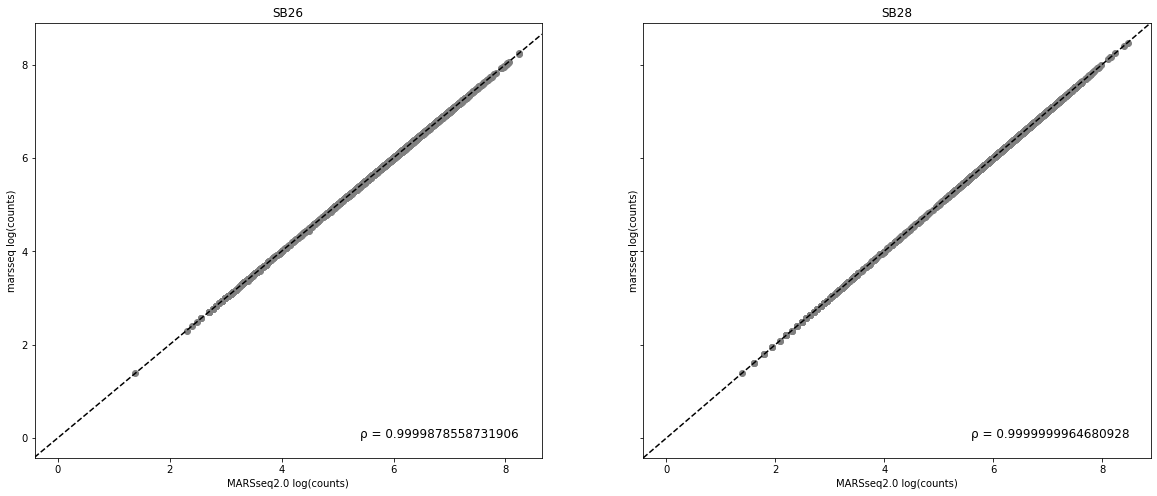

In [145]:
fig, ax = plt.subplots(1, 2, figsize=[20, 8], sharey=True)
ax[0].scatter(vanilla_sb26.obs.log1p_total_counts, mars_sb26.obs.log1p_total_counts, c='grey')
ax[0].set_title('SB26')
ax[0].set_xlabel('MARSseq2.0 log(counts)')
ax[0].set_ylabel('marsseq log(counts)')
ax[0].axline((0, 0), slope=1, color='black', linestyle='--')

ax[1].scatter(vanilla_sb28.obs.log1p_total_counts, mars_sb28.obs.log1p_total_counts, c='grey')
ax[1].set_title('SB28')
ax[1].set_xlabel('MARSseq2.0 log(counts)')
ax[1].set_ylabel('marsseq log(counts)')
ax[1].axline((0, 0), slope=1, color='black', linestyle='--')

ax[0].text(5.4, 0, f'ρ = {np.corrcoef(vanilla_sb26.obs.log1p_total_counts, mars_sb26.obs.log1p_total_counts)[0, 1]}', size=12)
ax[1].text(5.6, 0, f'ρ = {np.corrcoef(vanilla_sb28.obs.log1p_total_counts, mars_sb28.obs.log1p_total_counts)[0, 1]}', size=12)

Text(4.85, 0, 'ρ = 0.9999999999999999')

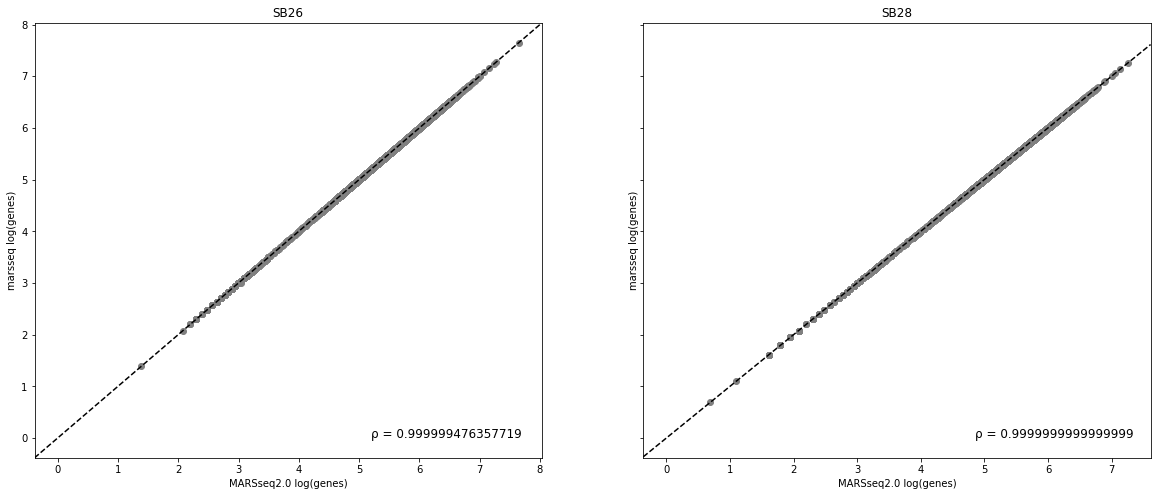

In [146]:
fig, ax = plt.subplots(1, 2, figsize=[20, 8], sharey=True)
ax[0].scatter(vanilla_sb26.obs.log1p_n_genes_by_counts, mars_sb26.obs.log1p_n_genes_by_counts, c='grey')
ax[0].set_title('SB26')
ax[0].set_xlabel('MARSseq2.0 log(genes)')
ax[0].set_ylabel('marsseq log(genes)')
ax[0].axline((0, 0), slope=1, color='black', linestyle='--')

ax[1].scatter(vanilla_sb28.obs.log1p_n_genes_by_counts, mars_sb28.obs.log1p_n_genes_by_counts, c='grey')
ax[1].set_title('SB28')
ax[1].set_xlabel('MARSseq2.0 log(genes)')
ax[1].set_ylabel('marsseq log(genes)')
ax[1].axline((0, 0), slope=1, color='black', linestyle='--')

ax[0].text(5.2, 0, f'ρ = {np.corrcoef(vanilla_sb26.obs.log1p_n_genes_by_counts, mars_sb26.obs.log1p_n_genes_by_counts)[0, 1]}', size=12)
ax[1].text(4.85, 0, f'ρ = {np.corrcoef(vanilla_sb28.obs.log1p_n_genes_by_counts, mars_sb28.obs.log1p_n_genes_by_counts)[0, 1]}', size=12)

In [147]:
!jupyter nbconvert --to html 00_pipeline.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 00_pipeline.ipynb to html
[NbConvertApp] Writing 705336 bytes to ../reports/00_pipeline.html
